# CARGA DE DATOS

__TODO__

In [1]:
from Utils import DatasetProcess, reconstruction_plot
from ConvModel import ConvModel
from AutoEncoder import TwoStepAutoEncoder, TwoStepClassifier, TwoStepTraining, OneStepAutoencoder, OneStepTraining
from OneClass import AnomalyDetector
from Contrastive import ContrastiveModel

In [2]:
(x_train, y_train), (x_test, y_test) = DatasetProcess.load()


# Aplicar la función hold_out
(x_train_no_labeled, x_train_labeled, y_train_labeled), (x_val, y_val), (x_test, y_test) = DatasetProcess.hold_out(
    (x_train, y_train), (x_test, y_test), validation_size=1000
)

x_train_labeled = x_train_labeled.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Verificar las dimensiones
print(f"Datos no etiquetados: {x_train_no_labeled.shape}")
print(f"Datos etiquetados entrenamiento: {x_train_labeled.shape}")
print(f"Etiquetas entrenamiento: {y_train_labeled.shape}")
print(f"Datos validación: {x_val.shape}")
print(f"Etiquetas validación: {y_val.shape}")
print(f"Datos prueba: {x_test.shape}")
print(f"Etiquetas prueba: {y_test.shape}")

Datos no etiquetados: (40000, 32, 32, 3)
Datos etiquetados entrenamiento: (9000, 32, 32, 3)
Etiquetas entrenamiento: (9000, 1)
Datos validación: (1000, 32, 32, 3)
Etiquetas validación: (1000, 1)
Datos prueba: (10000, 32, 32, 3)
Etiquetas prueba: (10000, 1)


# EJERCICIO 1

Entrena un modelo, creado sobre TensorFlow, haciendo uso únicamente de las instancias etiquetadas de entrenamiento. Dicho modelo debe de tener al menos cuatro capas densas y/o convolucionales.

Responde a las siguientes preguntas:

1. ¿Qué red has escogido? ¿Por qué? ¿Cómo la has entrenado?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Qué conclusiones sacas de los resultados detallados en el punto anterior?

In [3]:
model_base = ConvModel()
history_base = model_base.fit(
    x_train_labeled, 
    y_train_labeled,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=100
)

/Users/circus/repos/3year2sem/maai/maai_env/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-03 10:59:42.233000: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-03 10:59:42.233044: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-03 10:59:42.233054: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-03 10:59:42.233088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-03 10:59:42.233112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFl

Epoch 1/100


2025-04-03 10:59:43.711156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - accuracy: 0.0306 - loss: 9.2084 - val_accuracy: 0.0170 - val_loss: 8.0246
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.0612 - loss: 7.0118 - val_accuracy: 0.0130 - val_loss: 6.7237
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.0704 - loss: 5.8018 - val_accuracy: 0.0170 - val_loss: 6.0901
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.0690 - loss: 5.1963 - val_accuracy: 0.0400 - val_loss: 5.2593
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.0761 - loss: 4.8624 - val_accuracy: 0.0630 - val_loss: 4.9811
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.0859 - loss: 4.5966 - val_accuracy: 0.0830 - val_loss: 4.5131
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.0967 - loss: 4.4620 - val_accuracy: 0.0630 - val_loss: 4.7958
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.1056 - loss: 4.324

In [ ]:
# Evalúa con el conjunto de prueba
test_accuracy = model_base.score(x_test, y_test)
print(f"Accuracy en conjunto de prueba: {test_accuracy}")

In [ ]:
import numpy as np
np.unique(np.argmax(model_base(x_test),axis=1)) # >> array([60]) # solo predice la clase 60

In [ ]:
model_base.plot(history_base)

# EJERCICIO 2

Entrena el mismo modelo, incorporando las instancias no etiquetadas de entrenamiento mediante la técnica de auto-aprendizaje. Opcionalmente, se ponderará cada instancia de entrada en función de su calidad (o certeza).

Responde a las siguientes preguntas:
1. ¿Qué parámetros has definido para el entrenamiento?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en el Ejercicio 1?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [ ]:
# Función para crear modelos consistentes durante self-training
def create_model():
    return ConvModel(
        learning_rate=0.0005,  # Learning rate reducido para fine-tuning
        dropout_prob=0.25,     
        l2_lambda=0.005        
    )

# Normalizar datos no etiquetados
x_train_no_labeled = x_train_no_labeled.astype('float32') / 255.0

# Aplica self-training con datos no etiquetados
final_model = ConvModel.self_training_v2(
    model_func=create_model,
    x_train=x_train_labeled,
    y_train=y_train_labeled,  
    unlabeled_data=x_train_no_labeled,
    validation_data=(x_val, y_val),
    thresh=0.8,             # Umbral ligeramente más bajo para incluir más ejemplos
    train_epochs=5           # 5 iteraciones de self-training
)

# Evalúa el modelo final
final_accuracy = final_model.score(x_test, y_test)
print(f"Accuracy del modelo final con self-training: {final_accuracy}")
print(f"Mejora respecto al modelo base: {final_accuracy - test_accuracy:.4f}")

# EJERCICIO 3

Entrena un modelo de aprendizaje semisupervisado de tipo autoencoder en dos pasos (primero el autoencoder, después el clasificador). La arquitectura del encoder debe ser exactamente la misma que la definida en los Ejercicios 1 y 2, a excepción del último bloque de capas.

Responde a las siguientes preguntas:
1. ¿Cuál es la arquitectura del modelo? ¿Y sus hiperparámetros?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en los Ejercicios 1 y 2?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [2]:
unlabeled_train, x_train, y_train, x_val, y_val, x_test, y_test, one_hot_train, one_hot_val, one_hot_test = DatasetProcess.alt()

In [4]:
autoencoder = TwoStepAutoEncoder(
                                input_shape=unlabeled_train[0].shape,
                                learning_rate=0.006,
                                l2_lambda=0.0005,
                                dropout_prob=0.1)
classifier = TwoStepClassifier(
                              l2_lambda=0.0005,
                              dropout_prob=0.05,
                               learning_rate=0.05)


In [5]:
TwoStepTraining(autoencoder=autoencoder, 
                classifier=classifier, 
                x_train=x_train, 
                y_train=one_hot_train, 
                unlabeled_train=unlabeled_train, 
                validation_data=(x_val, one_hot_val),
                batch_size_autoencoder=256,
                epochs_autoencoder=1,
                batch_size_classifier=4096,
                epochs_classifier=405)

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


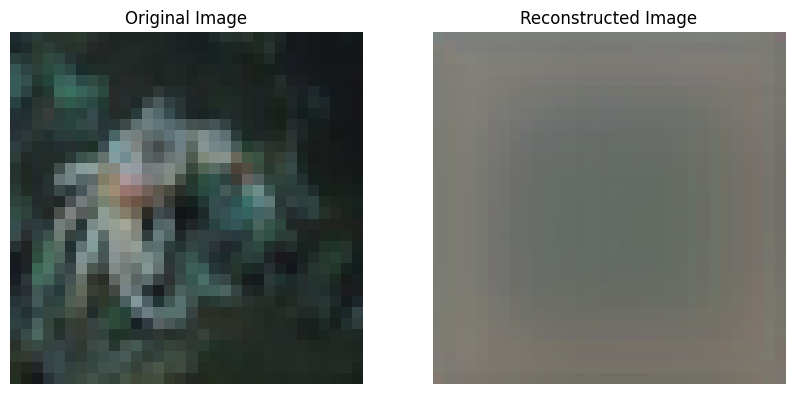

In [23]:
reconstruction_plot(autoencoder, x_test)

In [7]:
autoencoder.score(x_test)

AttributeError: 'TwoStepAutoEncoder' object has no attribute 'score'

# EJERCICIO 4

Entrena un modelo de aprendizaje semisupervisado de tipo autoencoder en un paso (autoencoder y clasificador al mismo tiempo). La arquitectura del autoencoder será la misma que la definida en el Ejercicio 3, y la combinación de encoder y clasificador será igual a la arquitectura definida en el
Ejercicio 1.

Responde a las siguientes preguntas:
1. ¿Cuál es la arquitectura del modelo? ¿Y sus hiperparámetros?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en los ejercicios anteriores?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [6]:
one_step_autoencoder = OneStepAutoencoder(input_shape=unlabeled_train[0].shape,
                                learning_rate=0.0015,
                                decoder_extra_loss_weight = 0.45,
                                l2_lambda=0.00005,
                                dropout_prob=0.05)

In [ ]:
h = OneStepTraining(one_step_autoencoder, 
                    x_train=x_train, 
                    y_train=one_hot_train, 
                    unlabeled_train=unlabeled_train,
                    batch_size=256,
                    epochs=1000,
                    patience=10)

Epoch 1/1000
 26/164 ━━━━━━━━━━━━━━━━━━━━ 3:21 1s/step - classifier_accuracy: 0.0138 - classifier_loss: 1.4888 - decoder_loss: 0.0773 - loss: 0.9773

In [ ]:
reconstruction_plot(one_step_autoencoder, x_test)

In [ ]:
one_step_autoencoder.score(x_test)

# EJERCICIO 5

Repite el mismo entrenamiento de los Ejercicios 1-4, pero eliminando las instancias no etiquetadas
más atípicas con respecto a los datos etiquetados. Se cumplirán los siguientes puntos:
- La arquitectura de la red de clasificación en una clase será la misma a la utilizada en el
clasificador del Ejercicio 1, a excepción de la capa de salida.
- Utiliza la técnica explicada en el Notebook 5, usando un valor de 𝑣 = 0,9.

Responde a la siguiente pregunta:
1. ¿Se mejoran los resultados con respecto a los anteriores ejercicios? ¿Qué conclusiones sacas de estos resultados?

In [ ]:
model = AnomalyDetector(input_shape=(32,32,3), 
                        nu=.9,
                        l2_lambda=0.0,
                        learning_rate=0.0001,
                        dropout_prob=0.05)
model.fit(x_train, 
          batch_size=256, 
          epochs=50, 
          delta=.025, 
          steps=100)

In [ ]:
import numpy as np

# TODO: Evalúa el modelo con los datos del conjunto de test. Indica el porcentaje de datos etiquetados como típicos, y visualiza los datos
predicciones = model.predict(x_test)

# Determinamos qué datos son típicos (normales) y cuáles son anomalías
# Un dato es típico si su predicción es mayor que r
r_valor = model.model.r.numpy()
es_tipico = predicciones > r_valor

# Calculamos el porcentaje de datos etiquetados como típicos
porcentaje_tipicos = np.mean(es_tipico) * 100

print(f"Valor de r: {r_valor:.4f}")
print(f"Porcentaje de datos etiquetados como típicos: {porcentaje_tipicos:.2f}%")
print(f"Porcentaje de datos etiquetados como anomalías: {100 - porcentaje_tipicos:.2f}%")

In [ ]:
np.unique(predicciones)

In [ ]:
# TODO: Evalúa el modelo con los datos del conjunto de outliers. Indica el porcentaje de datos etiquetados como atípicos, y visualiza los datos en conjunto con los de test
predicciones_outliers = model.predict(x_outliers)
r_valor = model.model.r.numpy()
es_atipico_outliers = predicciones_outliers <= r_valor
porcentaje_atipicos_outliers = np.mean(es_atipico_outliers) * 100

# Evaluamos también los datos de test para comparar
predicciones_test = model.predict(x_test)
es_atipico_test = predicciones_test <= r_valor

print(f"Porcentaje de outliers etiquetados como atípicos: {porcentaje_atipicos_outliers:.2f}%")

# EJERCICIO 6

Repite los Ejercicios 3-5 cambiando el autencoder por la técnica definida en el apartado “Hay vida más allá del autoencoder” del Notebook 4. Contesta a las preguntas de dichos ejercicios. Se cumplirán los siguientes puntos:

1. La arquitectura de la red será igual a la parte encoder del autencoder definido en los
ejercicios anteriores.
2. El modelo debe entrenar correctamente.

In [ ]:
cModel = ContrastiveModel(unlabeled_train[0].shape, 
                          learning_rate=0.05, 
                          lambda_param=.9,
                          l2_lambda=0.001)
cModel.train(unlabeled_train, 
             epochs=5, 
             batch_size=2048)
cModel.plot_training_history()

In [ ]:
n_samples = 100
test_samples = x_test[:n_samples].reshape(n_samples,32,32,3)

In [ ]:
n_samples = 100
test_samples = x_test[:n_samples].reshape(n_samples,32,32,3)

cModel.plot_similarity_matrix(test_samples, n_samples=n_samples);